In [25]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables
import io
import gzip
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras import backend as K,objectives
from keras.optimizers import Adam
from keras.models import model_from_json
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import CSVLogger

pd.set_option('display.max_columns', None)

In [27]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = '../../MSD_data/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

*Use Rhythm Histogram and Statistical Spectrum Descriptor data from http://www.ifs.tuwien.ac.at/mir/audiofeatureextraction.html to attempt to predict hotness*

In [28]:
rh_hotness_clean = pd.read_pickle(msd_subset_path+'rh_and_hotness_clean.pkl')
ssd_hotness_clean = pd.read_pickle(msd_subset_path+'ssd_and_hotness_clean.pkl')

*Check for duplicate tracks*

In [29]:
assert (ssd_hotness_clean.groupby('song_id').count()['track_id'] > 1).sum() == 0 
assert (rh_hotness_clean.groupby('song_id').count()['track_id'] > 1).sum() == 0

In [30]:
# For classification
# Simplify by only setting top 25% of song_hotness to be "hot" and the rest "not"

def convert_y_to_categorical(y_df, cutoff = 0.75):
    threshold = y_df.quantile(cutoff)
    Y = [0 if i < threshold else 1 for i in y_df]
    return np.array(Y)

In [31]:
# Outline taken from https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (width, height, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    else :
        x = Dense(1, activation="sigmoid")(x)
    # construct the CNN
    model = Model(inputs, x)
    return model

*Combine features into single dataset for training*

In [32]:
y = rh_hotness_clean.song_hotttnesss
x_rh = rh_hotness_clean.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)
x_ssd = ssd_hotness_clean.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)
x = np.concatenate((x_rh, x_ssd), axis = 1)
# df = ssd_hotness_clean # rh_hotness_clean
# x = df.drop(['track_id', 'song_id', 'song_hotttnesss'], axis = 1)

In [33]:
w_rh = 12 # 21 15
h_rh = 19 # 8  4

x = MinMaxScaler().fit_transform(x)
y_df = y
y = y.values

In [34]:
def getModelAndDs(x, y, w_rh, h_rh, regress) :
    (trainX, testX, trainY, testY) = train_test_split(x, y, test_size=0.25, random_state=109)
    trainX = np.expand_dims(trainX.reshape(trainX.shape[0], w_rh, h_rh), axis = -1)
    testX = np.expand_dims(testX.reshape(testX.shape[0], w_rh, h_rh), axis = -1)
    K.clear_session()

    model = create_cnn(w_rh, h_rh, 1, regress=regress)
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics = ['accuracy'])
    model.summary()
    return (model, trainX, testX, trainY, testY)

In [35]:
def fit(model, trainX, testX, trainY, testY, regress) :
    csv_logger = CSVLogger('history_regress{}.log'.format(regress), separator=',', append=False)
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=200, batch_size=8,
                                     callbacks=[csv_logger]);
    model.save_weights("audio_model_regress{}.h5".format(regress))
    model_json = model.to_json()
    with open("audio_model_regress{}.json".format(regress), "w") as json_file:
        json_file.write(model_json)
    loss, accuracy  = model.evaluate(testX, testY, verbose=False)
    return (model, history, loss, accuracy)

In [36]:
def display(history, loss, accuracy) :
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot((history.history['acc']), 'r', label='train')
    ax.plot((history.history['val_acc']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Accuracy', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)

In [37]:
regress = True
model, trainX, testX, trainY, testY = getModelAndDs(x, y, w_rh, h_rh, regress)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 19, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 19, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 19, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 19, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 9, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 9, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 9, 32)          0         
__________

In [38]:
model, history, loss, accuracy = fit(model, trainX, testX, trainY, testY, regress)

Train on 4236 samples, validate on 1412 samples
Epoch 1/200
4236/4236 [==============================] - 8s 2ms/step - loss: 6125932.1479 - acc: 0.2493 - val_loss: 237178262.4767 - val_acc: 0.0000e+00
Epoch 2/200
4236/4236 [==============================] - 7s 2ms/step - loss: 68070.4276 - acc: 0.2524 - val_loss: 95700.2355 - val_acc: 0.2585
Epoch 3/200
4236/4236 [==============================] - 7s 2ms/step - loss: 65061.0896 - acc: 0.2524 - val_loss: 72430.3399 - val_acc: 0.2585
Epoch 4/200
4236/4236 [==============================] - 7s 2ms/step - loss: 66608.2025 - acc: 0.2524 - val_loss: 114518.0179 - val_acc: 0.2585
Epoch 5/200
4236/4236 [==============================] - 7s 2ms/step - loss: 65089.8691 - acc: 0.2524 - val_loss: 74343.1729 - val_acc: 0.2585
Epoch 6/200
4236/4236 [==============================] - 7s 2ms/step - loss: 61717.4223 - acc: 0.2524 - val_loss: 2638.8682 - val_acc: 0.2585
Epoch 7/200
4236/4236 [==============================] - 7s 2ms/step - loss: 75831.0

4236/4236 [==============================] - 7s 2ms/step - loss: 51028.1977 - acc: 0.2524 - val_loss: 118966.8934 - val_acc: 0.2585
Epoch 58/200
4236/4236 [==============================] - 7s 2ms/step - loss: 58641.5086 - acc: 0.2524 - val_loss: 64038.3658 - val_acc: 0.2585
Epoch 59/200
4236/4236 [==============================] - 7s 2ms/step - loss: 54585.8324 - acc: 0.2524 - val_loss: 57311.0592 - val_acc: 0.2585
Epoch 60/200
4236/4236 [==============================] - 6s 2ms/step - loss: 56219.8803 - acc: 0.2524 - val_loss: 4815.2347 - val_acc: 0.2585
Epoch 61/200
4236/4236 [==============================] - 7s 2ms/step - loss: 55997.6809 - acc: 0.2524 - val_loss: 43698.2994 - val_acc: 0.2585
Epoch 62/200
4236/4236 [==============================] - 7s 2ms/step - loss: 50546.4644 - acc: 0.2524 - val_loss: 39001.4760 - val_acc: 0.2585
Epoch 63/200
4236/4236 [==============================] - 7s 2ms/step - loss: 65166.8250 - acc: 0.2524 - val_loss: 28259.2342 - val_acc: 0.2585
Epoch

Epoch 114/200
4236/4236 [==============================] - 7s 2ms/step - loss: 47254.3167 - acc: 0.2524 - val_loss: 47013.1566 - val_acc: 0.2585
Epoch 115/200
4236/4236 [==============================] - 7s 2ms/step - loss: 42703.7688 - acc: 0.2524 - val_loss: 47330.0359 - val_acc: 0.2585
Epoch 116/200
4236/4236 [==============================] - 7s 2ms/step - loss: 39682.3140 - acc: 0.2524 - val_loss: 22768.9244 - val_acc: 0.2585
Epoch 117/200
4236/4236 [==============================] - 7s 2ms/step - loss: 43630.5796 - acc: 0.2524 - val_loss: 139215.0975 - val_acc: 0.2585
Epoch 118/200
4236/4236 [==============================] - 7s 2ms/step - loss: 53786.8731 - acc: 0.2524 - val_loss: 28477.8047 - val_acc: 0.2585
Epoch 119/200
4236/4236 [==============================] - 6s 1ms/step - loss: 50028.5508 - acc: 0.2524 - val_loss: 118510.4411 - val_acc: 0.2585
Epoch 120/200
4236/4236 [==============================] - 6s 1ms/step - loss: 39313.5859 - acc: 0.2524 - val_loss: 33751.3921 -

4236/4236 [==============================] - 7s 2ms/step - loss: 42012.0928 - acc: 0.2524 - val_loss: 48172.0580 - val_acc: 0.2585
Epoch 171/200
4236/4236 [==============================] - 7s 2ms/step - loss: 43608.4190 - acc: 0.2524 - val_loss: 82503.2768 - val_acc: 0.2585
Epoch 172/200
4236/4236 [==============================] - 7s 2ms/step - loss: 40660.2525 - acc: 0.2524 - val_loss: 21129.6058 - val_acc: 0.2585
Epoch 173/200
4236/4236 [==============================] - 7s 2ms/step - loss: 56635.8135 - acc: 0.2524 - val_loss: 19661.1189 - val_acc: 0.2585
Epoch 174/200
4236/4236 [==============================] - 7s 2ms/step - loss: 34798.6593 - acc: 0.2524 - val_loss: 55214.4593 - val_acc: 0.2585
Epoch 175/200
4236/4236 [==============================] - 7s 2ms/step - loss: 50715.1416 - acc: 0.2524 - val_loss: 55572.4556 - val_acc: 0.2585
Epoch 176/200
4236/4236 [==============================] - 7s 2ms/step - loss: 44965.2824 - acc: 0.2524 - val_loss: 36278.0062 - val_acc: 0.2585

Test loss: 1.7e+05
Test accuracy: 0.258


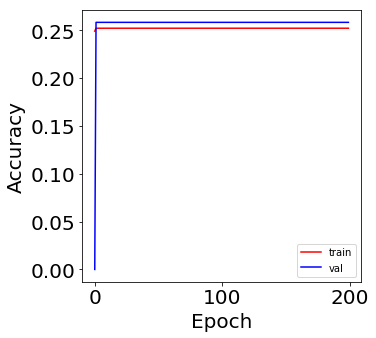

In [39]:
display(history, loss, accuracy) 

In [40]:
y_pred = model.predict(np.expand_dims(x.reshape(x.shape[0], w_rh, h_rh), axis = -1))

In [41]:
print('Model test MSE: {}'.format(mean_squared_error(y_pred, y)))


Model test MSE: 0.17908436245652246


In [42]:
(y_pred > 0.1).sum()

0

*Not good - no hotness predicted. Now try classification*

In [43]:
y = convert_y_to_categorical(y_df)
y = y.astype('int')

print("{} % of the songs are classified as hot, while the rest is not".format(y.mean()*100))

25.106232294617563 % of the songs are classified as hot, while the rest is not


In [44]:
regress = False
model, trainX, testX, trainY, testY = getModelAndDs(x, y, w_rh, h_rh, regress)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 19, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 19, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 19, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 19, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 9, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 9, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 9, 32)          0         
__________

In [45]:
model, history, loss, accuracy = fit(model, trainX, testX, trainY, testY, regress)

Train on 4236 samples, validate on 1412 samples
Epoch 1/200
4236/4236 [==============================] - 8s 2ms/step - loss: 84848068.4858 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 2/200
4236/4236 [==============================] - 7s 2ms/step - loss: 2528774.1201 - acc: 0.7517 - val_loss: 438702.9842 - val_acc: 0.7408
Epoch 3/200
4236/4236 [==============================] - 7s 2ms/step - loss: 740683.6003 - acc: 0.7517 - val_loss: 119199.3040 - val_acc: 0.7408
Epoch 4/200
4236/4236 [==============================] - 7s 2ms/step - loss: 341962.8794 - acc: 0.7517 - val_loss: 31353.8175 - val_acc: 0.7408
Epoch 5/200
4236/4236 [==============================] - 6s 2ms/step - loss: 211981.9188 - acc: 0.7517 - val_loss: 21750.0394 - val_acc: 0.7408
Epoch 6/200
4236/4236 [==============================] - 7s 2ms/step - loss: 141877.8748 - acc: 0.7517 - val_loss: 4684.1164 - val_acc: 0.7408
Epoch 7/200
4236/4236 [==============================] - 7s 2ms/step - loss: 90183.7225

4236/4236 [==============================] - 7s 2ms/step - loss: 34.2342 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 60/200
4236/4236 [==============================] - 7s 2ms/step - loss: 25.1725 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 61/200
4236/4236 [==============================] - 7s 2ms/step - loss: 25.1584 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 62/200
4236/4236 [==============================] - 7s 2ms/step - loss: 25.1936 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 63/200
4236/4236 [==============================] - 7s 2ms/step - loss: 31.4200 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 64/200
4236/4236 [==============================] - 7s 2ms/step - loss: 25.0669 - acc: 0.7517 - val_loss: 271738436.8952 - val_acc: 0.7408
Epoch 65/200
4236/4236 [==============================] - 7s 2ms/step - loss: 31.9054 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 66/200
4236/4236 [================

4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 119/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 120/200
4236/4236 [==============================] - 6s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 121/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 122/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 123/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 124/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 125/200
4236/4236 [================

Epoch 177/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 178/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 179/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 180/200
4236/4236 [==============================] - 7s 2ms/step - loss: 30.0973 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 181/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 182/200
4236/4236 [==============================] - 7s 2ms/step - loss: 24.8347 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 183/200
4236/4236 [==============================] - 7s 2ms/step - loss: 28.7113 - acc: 0.7517 - val_loss: 25.9207 - val_acc: 0.7408
Epoch 184/200
4236/4236 [==

Test loss: 25.9
Test accuracy: 0.741


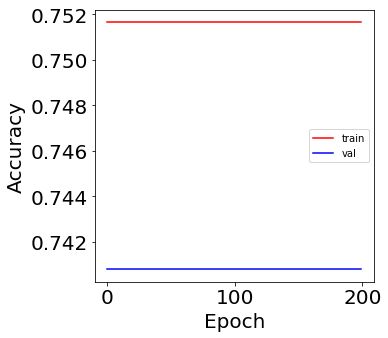

In [46]:
display(history, loss, accuracy) 

In [47]:
y_pred = model.predict(np.expand_dims(x.reshape(x.shape[0], w_rh, h_rh), axis = -1))

In [48]:
print('Accuracy - classification', accuracy_score(y, y_pred))

Accuracy - classification 0.7489376770538244


*~75% accuracy - much better than for regression but still no improvement over baseline*